### Task 1: Import libraries

In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.models import Model, load_model
import os
import numpy as np
import cv2
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

### Task 2: Dataset

We are using the face mask dataset, which is already splitted into training, testing and validation data. <br/>
Let's transform (rescale, rotate etc.) that dataset to avoid overfitting.

In [2]:
# [0,1,255, 60, 28]
255/255

1.0

In [9]:
img_width, img_height = 224, 224
base_dir = 'dataset/'
train_data_dir = base_dir + 'Train'
validation_data_dir = base_dir + 'Validation'

train_samples = 10000
validation_samples=800

epochs = 5
batch_size = 16

# Rescale images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Task 3: Build model to detect mask and unmask

- Loading Pre-trained VGG16 Model : We choose VGG16 as our Convolutional Neural Network

In [5]:
input_shape = Input(shape=(224, 224, 3))
model = VGG16(input_tensor=input_shape, include_top=True, weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

- customizing the model: Adding few layers

In [6]:
last_layer = model.get_layer('block5_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(2, activation='softmax', name='output')(x) # Because we have two classes/nodes at the output layer: with_mask and without_mask

custom_vgg_model2 = Model(input_shape, out)
custom_vgg_model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

- Freezing Layers: To implement training process on added layers only

In [7]:
for layer in custom_vgg_model2.layers[:-4]:
    layer.trainable = False
for layer in custom_vgg_model2.layers:
    print(layer.name, ':', layer.trainable)

input_1 : False
block1_conv1 : False
block1_conv2 : False
block1_pool : False
block2_conv1 : False
block2_conv2 : False
block2_pool : False
block3_conv1 : False
block3_conv2 : False
block3_conv3 : False
block3_pool : False
block4_conv1 : False
block4_conv2 : False
block4_conv3 : False
block4_pool : False
block5_conv1 : False
block5_conv2 : False
block5_conv3 : False
block5_pool : False
flatten : True
fc1 : True
fc2 : True
output : True


### Task 4: Compile the Model

In [8]:
custom_vgg_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<b>Loss Function</b>: Lets select the categorical cross-entropy loss function for this model. When dealing with multi-class classification problems such as image classification where each input can only belong to one class categorical cross-entropy is frequently used. This loss function computes the discrepancy between the classes actual probability distribution and their predicted probability distribution. The model is encouraged to make more accurate predictions because it is penalized more heavily when it predicts probabilities that are further from the actual class labels.

<b>Learning rate</b>: Let's choose the default learning rate which is 0.001 for VGG16. It is considered as the best value for most of the classification Problems

<b>Optimizer</b>: Let's choose adam optimizer, which combines two popular optimizers i.e. RMSprop and AdaGrad and known for its fast convergence and good performance on a number of deep learning tasks.

<b>Metrics</b>: Accuracy is really important for understanding how well the model is doing with classifying things. It tells us the percentage of correctly classified items out of everything we looked at. Accuracy works alongside the loss function to give us a good overview of how the model is performing. It helps us see how good the model is for what we're trying to do.

### Task 5: Train and Test the model

- Defining Callback to stop the training process early with best result

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [4]:
10//3

3

In [13]:
history = custom_vgg_model2.fit_generator(train_generator,
                                steps_per_epoch=10000 // batch_size,
                                epochs=5,
                                validation_data=validation_generator,
                                validation_steps=800 // batch_size,
                                callbacks=[early_stopping]
                                         )

C:\Users\AMAN\AppData\Local\Temp\ipykernel_18540\758139776.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = custom_vgg_model2.fit_generator(train_generator,


Epoch 1/5
625/625 [==============================] - 2678s 4s/step - loss: 0.0827 - accuracy: 0.9707 - val_loss: 0.0254 - val_accuracy: 0.9937
Epoch 2/5
625/625 [==============================] - 2558s 4s/step - loss: 0.0588 - accuracy: 0.9790 - val_loss: 0.0203 - val_accuracy: 0.9925
Epoch 3/5
625/625 [==============================] - 3513s 6s/step - loss: 0.0453 - accuracy: 0.9841 - val_loss: 0.0285 - val_accuracy: 0.9887
Epoch 4/5
625/625 [==============================] - 2697s 4s/step - loss: 0.0426 - accuracy: 0.9859 - val_loss: 0.0204 - val_accuracy: 0.9925
Epoch 5/5
625/625 [==============================] - 2288s 4s/step - loss: 0.0382 - accuracy: 0.9871 - val_loss: 0.0298 - val_accuracy: 0.9925


<b>Epochs: </b>The Number of epochs defines how many times the data will be passed forward and backward during the training process. As in our case, our dataset is too big (10000 training samples and 1000 testing samples), we will set this value to 5 epochs, otherwise, it may take too long to finish the training process. However, earlystop callback can stop the training process when it finds the optimized accuracy.

<b>Batch Size</b>: The batch size determines the number of samples that will be processed by the model in each training iteration. We will choose batch size as 16, so the steps per epoch will be 10000/16 = 625. As smaller batch size allows efficient use of hardware resources and can introduce more noise into the gradient estimates, which can help avoid the model from getting stuck in local minima during optimization.

<b>TRAINING HISTORY VISUALIZATION </b>

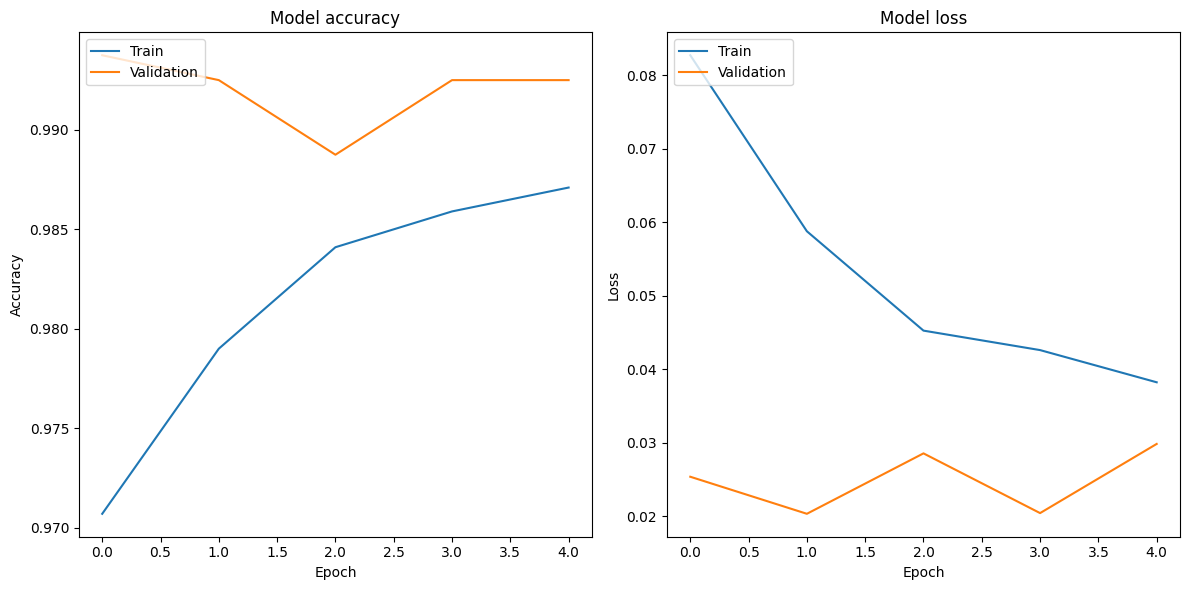

In [40]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

This graph can change with the number of epochs

- Saving the model

In [17]:
custom_vgg_model2.save('face_mask_fine_tune_model.h5')

- loading the trained model

In [5]:
from keras.models import load_model

In [6]:
new_model = load_model('face_mask_fine_tune_model.h5')

- <b>MODEL TESTING</b>

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [27]:
test=cv2.imread(base_dir+'Test/WithoutMask/92.png')
print(test.shape)

(124, 124, 3)


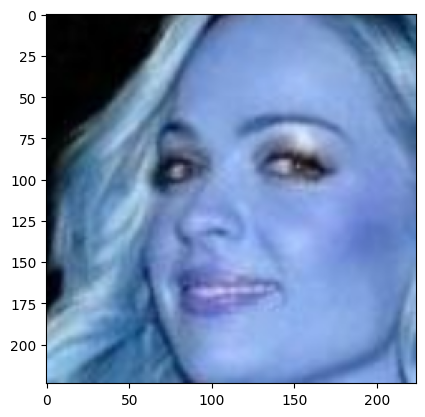

In [28]:
test = cv2.resize(test,(224,224))
plt.imshow(test)

In [29]:
test = test.astype('float')/255
test = test.reshape(1,224,224,3)

In [31]:
p=new_model.predict(test)
p

1/1 [==============================] - 0s 423ms/step


array([[9.1721483e-07, 9.9999905e-01]], dtype=float32)

In [33]:
classess = {0:'With Mask',1:'Without Mask'}
p=new_model.predict(test).argmax()
print("Predicted Class:",p)

print("Predicted class label: ", classess[p])
print("Prediction Class Probabilities: ", new_model.predict(test))
print("Class '0' Probability: ", new_model.predict(test)[0][0])
print("Class '1' Probability: ", new_model.predict(test)[0][1])

1/1 [==============================] - 0s 407ms/step
Predicted Class: 1
Predicted class label:  Without Mask
1/1 [==============================] - 0s 400ms/step
Prediction Class Probabilities:  [[9.1721483e-07 9.9999905e-01]]
1/1 [==============================] - 0s 382ms/step
Class '0' Probability:  9.1721483e-07
1/1 [==============================] - 0s 438ms/step
Class '1' Probability:  0.99999905


- <b>LET's TEST ON THE NUMBER OF SAMPLES</b>

1/1 [==============================] - 0s 376ms/step


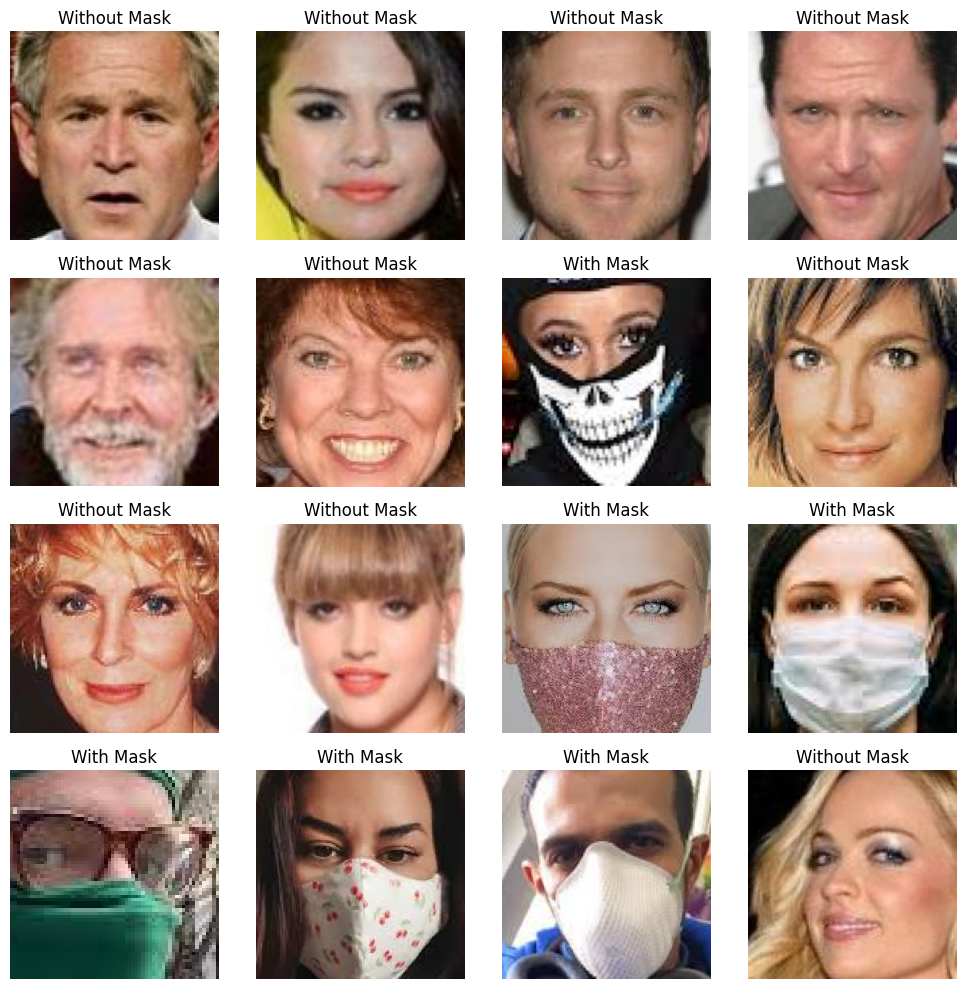

In [35]:

# Prepare subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

test_dir = base_dir + 'TestData/'
test_images = os.listdir(test_dir)

# Iterate over test images and make predictions
for i, img_name in enumerate(test_images):
    img_path = os.path.join(test_dir, img_name)
    image_ = cv2.imread(img_path)
    # Image pre-processing
    test = cv2.resize(image_, (224, 224))
    test = test.astype('float') / 255
    test = test.reshape(1, 224, 224, 3)
    
    # Predict class probabilities
    prediction = new_model.predict(test)

    # Get predicted class
    prediction_class = prediction.argmax()

    # Get Predicted Label
    prediction_label = classess[prediction_class]
    
    # Read and display the image with label
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(prediction_label)
    axes[i].axis('off')

plt.tight_layout()
plt.show()
